In [16]:
#from google.colab import drive
#drive.mount('/content/drive')
#import os 
#os.chdir("/content/drive/MyDrive/Proyecto_Transitos_DHA1001/DHA1001_Transito")
import astroscrappy
import photutils
import astroalign
import matplotlib.pyplot as plt
from transitos_dha1001 import *
# mine
from agregado import *

In [17]:
data_loc = "data/"
recalc=False

# Introducción

ho-la

# Desarrollo - análisis de datos WASP-103 \[1\]
## I. Reducción de las imágenes del tránsito\[2\]
Para poder analizar las fotos de este tránsito, es necesario reducir estos datos y generar imágenes de calibración con las que removeremos algunos defectos presentes en las imágenes a estudiar.
Una vez hayan sido filtradas, volveremos a centrar las imágenes dejándolas listas analizar los datos.

# Desarrollo
## I. Análisis de datos sobre el transito de wasp-103b


In [56]:
# Generamos los grupos de imagenes para cada reducción que llevaremos a cabo.
bias_stuff = [ "Bias{0:08d}.fit".format(i) for i in range(319,329) ]
dark_stuff = [ "Dark{0:08d}.fit".format(i) for i in range(313,318) ]
flat_stuff = [ "FLAT_sloan_r_B22-{0:03d}.fit".format(i) for i in range(1,6)]
# Y el grupo de imagenes que estudiaremos
waw_science = [ "{0:08d}.fit".format(i) for i in range(1,94)]

In [159]:
# calculamos la mediana de las imagenes BIAS
crear_masterbias(bias_stuff,
                 "MasterBias.fits",
                 data_loc+"wasp103_raw",
                 data_loc+"wasp103_red",
                 recalc)

In [160]:
# se resta el bias a las fotos y se calcula la mediana de todas las fotos DARK
crear_masterdark(dark_stuff,
                 "MasterDark.fits",
                 "MasterBias.fits",
                 data_loc+"wasp103_raw",
                 data_loc+"wasp103_red", 
                 recalc) 

In [161]:
# se resta el bias y el dark y se calcula la mediana de las fotos FLAT
crear_masterflat(flat_stuff,
                 "MasterFlat.fits",
                 "MasterDark.fits",
                 "MasterBias.fits",
                 data_loc+"wasp103_raw",
                 data_loc+"wasp103_red",
                 recalc)

In [162]:
# aplicamos las reducciones generados a las imagenes que queremos estudiar
reducir_imagenes_ciencia( waw_science, 
                          reyeccion_rayos_cosmicos=True,
                          nombre_flat="MasterFlat.fits",
                          nombre_dark="MasterDark.fits",
                          nombre_bias="MasterBias.fits",
                          directorio_imagenes_originales= data_loc+"wasp103_raw", 
                          directorio_imagenes_reducidas= data_loc+"wasp103_red", 
                          recalcular= recalc)

In [163]:
# alineamos las imagenes
waw_science_reduced = [ "ciencia_{0:08d}.fit".format(i) for i in range(1,94) ]
alinear_imagenes_ciencia( waw_science_reduced,
                          prefijo='ali',
                          directorio_imagenes_reducidas= data_loc+"wasp103_red",
                          recalcular= recalc)

## II. Correcciones necesarias  \[3\]
ho-la
### a) Substracción del valor de fondo del cielo
Cuando se quiere observar cuerpos fuera de la atmosfera, es prácticamente imposible garantizar que en una fotografía, todas las cuentas registradas por el sensor son atribuibles única y exclusivamente a la incidencia de la luz procedente de los cuerpos celestes en la superficie del CCD. 
En el campo visual de la cámara, existe una gran cantidad de fuentes luminosas que se suman con los rayos percibidos del objeto de estudio, entre los cuales es posible mencionar a la Luna, la cual genera un fondo uniforme con cierto brillo grisáceo en las fotografías; y a la luz artificial de la ciudad en la cual se encuentra ubicado el observatorio, conocida con el término de **contaminación lumínica**. En el caso del observatorio el Sauce, se encuentra en un lugar con muy poca contaminación lumínica entregando condiciones óptimas para llevar a cabo observaciones astronómicas.

<img src="https://i.imgur.com/nqGytnW.png" style="height: 450px; width: 500px" />

Afortunadamente, gracias a que este brillo proviene de la interacción de la luz de la Luna y de las ciudades con la atmósfera terrestre, es posible considerar que su valor permanece constante a lo largo y ancho del fotograma original. De esta forma, será suficiente con seleccionar una porción de la fotografía que no contenga estrellas, para allí estimar el valor del fondo del cielo, el cual, al tratarse de un ruido aditivo, debe ser sustraído de las fotografías antes de iniciar el proceso de fotometría.


In [63]:
pos_referencia = dao_busqueda("ali_ciencia_00000001.fit",
                              directorio_imagenes_reducidas= data_loc+"wasp103_red",
                              directorio_fotometria= data_loc+"wasp103_fot",
                              recalcular = recalc)

In [80]:
#Filtrar zonas de la imagen con estrellas saturadas y otros problemas.
zonas_a_filtrar = [(426,255),(1223,1485),(225,1345),(1068,771)]

pos_referencia = filtrar_posiciones("ali_ciencia_00000001.fit", zonas_a_filtrar, directorio_fotometria=data_loc+"wasp103_fot")

In [81]:
# encontrar las fuentes en el resto de la imagen
img_reducidas_alineadas = [ "ali_ciencia_{0:08d}.fit".format(i) for i in range(1,94) ]
for imagen in img_reducidas_alineadas[1:]:
    _ = dao_recentrar(imagen,
                      pos_referencia, 
                      directorio_imagenes_reducidas= data_loc+"wasp103_red",
                      directorio_fotometria= data_loc+"wasp103_fot", 
                      caja_busqueda=21,
                      recalcular = True)

In [107]:
# medir la fotometría de apertura
for imagen in img_reducidas_alineadas[1:]:
    print("a", end="")
    _, _ = medir_fotometria(imagen, r_ap=7.0,
                     directorio_imagenes_reducidas= data_loc+"wasp103_red",
                     directorio_fotometria= data_loc+"wasp103_fot", 
                     bkg_type='global',
                     recalcular= True)
    

aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa

In [157]:
x_wasp103 = 1039
y_wasp103 = 1132 

mjd, mag, mag_err = curva_de_luz(img_reducidas_alineadas, 
                                 x_wasp103, y_wasp103, 
                                 directorio_imagenes_reducidas= data_loc+"wasp103_red",
                                 directorio_fotometria= data_loc+"wasp103_fot")

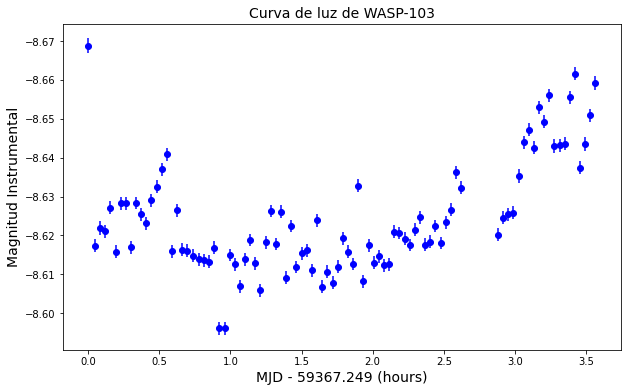

In [158]:
graficar_curva_de_luz(mjd, mag, mag_err, titulo="Curva de luz de WASP-103")

## II. Reducciones aplicadas
Para poder analizar las fotos de este tránsito, es necesario reducir estos datos y generar imágenes de calibración con las que removeremos algunos defectos presentes en las imágenes a estudiar.
Una vez hayan sido filtradas, volveremos a centrar las imágenes dejándolas listas analizar los datos.

### a) Bias reduction
Las cámaras CCD y su electrónica tienen un ruido intrínseco que añade señal a cada imagen tomada. Los **bias frames** se usan para compensar el ruido de la lectura.
Esta calibracion se ocupan imagenes generadas sin exponer el CCD, de esta forma obtendremos el valor de la desviación presente en los pixeles del CCD y podremos corregir cualquier imagen.

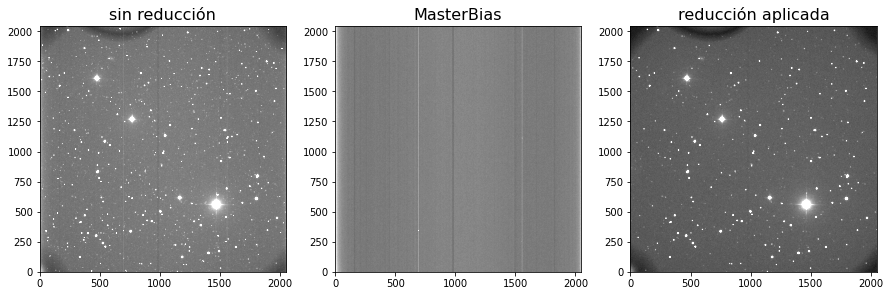

In [149]:
reducir_imagenes_ciencia(waw_science,'soloBias',True,None,None,"MasterBias.fits",data_loc+"wasp103_raw",data_loc+"wasp103_red",recalc)
plt.figure(figsize=(15,10))
agregar_imagen( plt.subplot(1,3,1), data_loc+"wasp103_raw/00000072.fit", titulo="sin reducción")
agregar_imagen( plt.subplot(1,3,2), data_loc+"wasp103_red/MasterBias.fits", titulo="MasterBias")
agregar_imagen( plt.subplot(1,3,3), data_loc+"wasp103_red/soloBias_00000072.fit", titulo="reducción aplicada")

### b) Dark reduction
Los movimientos térmicos de los electrones en el chip generan lentamente señales en proporción al tiempo de exposición, no por estar expuesto a la luz óptica sino por que esos electrones térmicos tienen oportunidad de apilarse en capa píxel a lo largo del transcurso del tiempo. Los **dark frames** estan diseñados para cuantificar la corriente oscura o ruido térmico del chip CCD de forma que puedan restarlo a las imágenes Astronómicas. Los "pixeles calientes" generalmente pueden ser controlados con una buena regulación de temperatura y disminuye conforme a la temperatura del chip va bajando

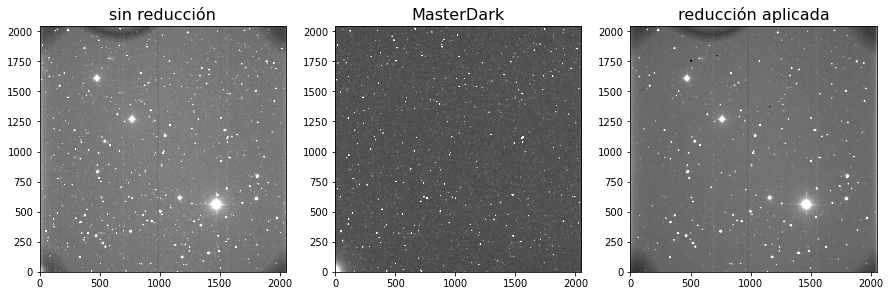

In [151]:
reducir_imagenes_ciencia(waw_science,'soloDark',True,None,"MasterDark.fits",None,data_loc+"wasp103_raw",data_loc+"wasp103_red",recalc)
plt.figure(figsize=(15,10))
agregar_imagen( plt.subplot(1,3,1), data_loc+"wasp103_raw/00000072.fit", titulo="sin reducción")
agregar_imagen( plt.subplot(1,3,2), data_loc+"wasp103_red/MasterDark.fits", titulo="MasterDark")
agregar_imagen( plt.subplot(1,3,3), data_loc+"wasp103_red/soloDark_00000072.fit", titulo="reducción aplicada")

### c) Flat reduction
Los **flat frames** se usan para compensar los problemas en el recorrido de la luz a través del telescopio hacia el sensor. Cosas como el polvo en las superficies ópticas, reflejos en los deflectores ("baffles") y ópticas alineadas incorrectamente pueden causar gradientes en la cantidad de luz que pasa a través del sistema.

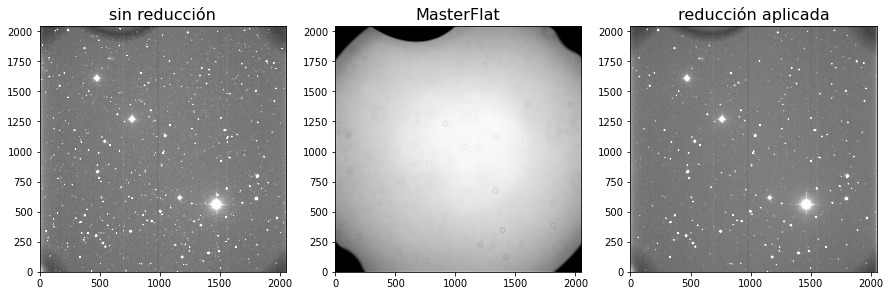

In [153]:
reducir_imagenes_ciencia(waw_science,'soloFlat',True,None,None,"MasterFlat.fits",data_loc+"wasp103_raw",data_loc+"wasp103_red",recalc)
plt.figure(figsize=(15,10))
agregar_imagen( plt.subplot(1,3,1), data_loc+"wasp103_raw/00000072.fit", titulo="sin reducción")
agregar_imagen( plt.subplot(1,3,2), data_loc+"wasp103_red/MasterFlat.fits", titulo="MasterFlat")
agregar_imagen( plt.subplot(1,3,3), data_loc+"wasp103_red/soloFlat_00000072.fit", titulo="reducción aplicada")

## III. Correcciones necesarias
ho-la
### a) Substracción del valor de fondo del cielo
Cuando se quiere observar cuerpos fuera de la atmosfera, es prácticamente imposible garantizar que en una fotografía, todas las cuentas registradas por el sensor son atribuibles única y exclusivamente a la incidencia de la luz procedente de los cuerpos celestes en la superficie del CCD. 
En el campo visual de la cámara, existe una gran cantidad de fuentes luminosas que se suman con los rayos percibidos del objeto de estudio, entre los cuales es posible mencionar a la Luna, la cual genera un fondo uniforme con cierto brillo grisáceo en las fotografías; y a la luz artificial de la ciudad en la cual se encuentra ubicado el observatorio, conocida con el término de **contaminación lumínica**. En el caso del observatorio el Sauce, se encuentra en un lugar con muy poca contaminación lumínica entregando condiciones óptimas para llevar a cabo observaciones astronómicas.

<img src="https://i.imgur.com/nqGytnW.png" style="height: 450px; width: 500px" />

Afortunadamente, gracias a que este brillo proviene de la interacción de la luz de la Luna y de las ciudades con la atmósfera terrestre, es posible considerar que su valor permanece constante a lo largo y ancho del fotograma original. De esta forma, será suficiente con seleccionar una porción de la fotografía que no contenga estrellas, para allí estimar el valor del fondo del cielo, el cual, al tratarse de un ruido aditivo, debe ser sustraído de las fotografías antes de iniciar el proceso de fotometría.

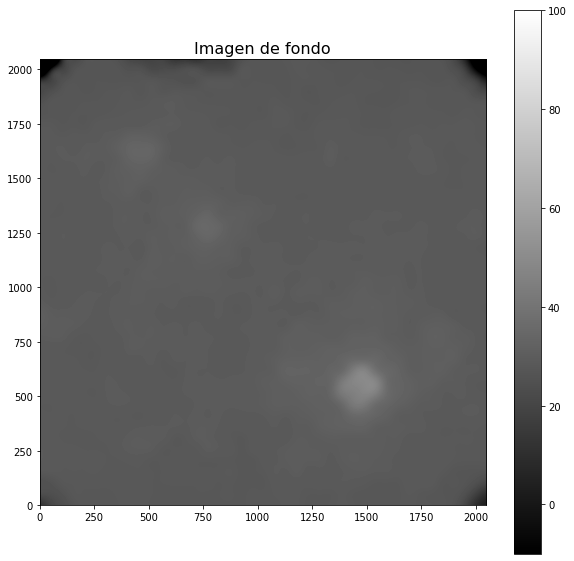

In [156]:
 desplegar_imagen(data_loc+"wasp103_red/ali_ciencia_00000001.bkg.fits", titulo='Imagen de fondo', cmin=-10, cmax=100)

### b) Fotometría
Una vez las imágenes han sido pre-procesadas y se les ha substraído el valor de
fondo, podemos iniciar la medición del cambio de brillo registrado por el cuerpo
celeste en estudio. La estimación de los cambios presentados en la intensidad
luminosa percibida de una estrella, puede realizarse por medio de 2 metodologías:

1. Fotometría absoluta
En esta metodología, es necesario medir la masa de aire presente en el ángulo cenital
y el coeficiente de extinción atmosférica cada vez que se tomen las fotografía. 

2. Fotometría diferencial

Podemos dividir este proceso en 6 pasos:

1. Verificar las imágenes

A pesar de que ya se halla hecho algún tipo de revisión previa, es recomendado
revisar que ninguna estrella esté saturada, aunque no observemos derrames en
alguna estrella, esto no significa que no pueda estar saturada. Una forma de
ver si la imagen de una estrella está saturada o no es examinar la gráfica de
la función de dispersión puntual (PSF) del perfil de brillo de la estrella.
Si la parte superior de la curva aparece plana, lo más probablemente es que
la haya saturado el sensor y no habrá manera de calcular la magnitud correcta.

Dentro de esta experiencia, si existió la presencia de estrellas saturadas aun
que estas fueron entregadas en conjunto a los datos del tránsito por lo que
no fue necesario la implementación de este paso.

2. Identificar las estrellas

Hay que tener mucho cuidado al momento de definir las coordenadas de la estrella
a estudiar, es muy fácil confundirla por una estrella más brillante o una
vecina.
Para esta experiencia se hizo uso de herramientas como IRSA para asegurarnos encontrar
la posicion exacta de la estrella en las fotos de referencia.


3. Ajustar la apertura

Para medir la cantidad de energía lumínica recibida por unidad de tiempo en esta
experiencia se ocupó un método llamado **apertura fotométrica**, este consiste
en medir la intensidad de luz en pequeños círculos o aperturas, centrados en
estrellas individuales de nuestras imágenes.

Las aperturas están formadas por 3 partes:

- **Apertura de estrella**: este es el círculo más interno, que rodea la estrella
  que estamos midiendo.
- **Hueco**: Es simplemente un espacio entre el círculo de señal y la corona de cielo.
- **Corona de cielo**: es el círculo más externo que se utiliza para obtener
información sobre el fondo de cielo.

[ foto de la apertura ]

4. Seleccionar las estrellas de verificación y comparación

Este paso es muy importante para evitar que nuestros resultados varíen demasiado.
Debido a que es muy común que aparezcan otros cuerpos celestes en las fotografías
que no presentan variabilidad, los ocuparemos para medir el cambio en el brillo
del cuerpo de interés.

Este método presenta la ventaja de que, al basarse en una comparación con otro
objeto presente en la imagen, los coeficientes necesarios en la fotometría absoluta
se mantendrán constantes, de tal manera que se cancelaran a la hora de establecer
la diferencia existente entre el brillo de las estrellas. Esto se traduce en una
drástica disminución en la complejidad del montaje instrumental utilizado. 

5. Medir las magnitudes

En este paso se hace el conteo de fotones capturados (después de haber reducido
los datos), cuya fórmula seria

 $\Delta v  = \ v_{medido} - c_{medido}$

Con
- v = magnitud instrumental de la estrella a estudiar.
- c = magnitud instrumental de la estrella de comparación.


6. Determinar la incertidumbre

Las magnitudes que medimos solo proporcionan parte de la información de nuestra
observación. Cada parte válida de datos científicos viene no solo con una medida
sino que también con una incertidumbre, la cual le indica a los investigadores
que usen nuestros datos cómo de precisas son nuestras mediciones.

La incertidumbre de nuestras mediciones contendrán tanto un componente aleatorio
como un componente sistemático. En todos los casos, se calcula la incertidumbre
usando la ecuación de la desviación típica.

## IV. Cambio fraccional en el brillo y V. error presente en los calculos
Teniendo en cuenta la curva de luz que calculamos en (I) necesitamos calcular cual fue la magnitud detectada antes y durante el trafico. Aun que existen tecnicas mas complejas y precisas, en esta
experiencia, mantendremos este calculo simple y solamente generaremos una estimacion estadistica

In [245]:
import numpy as np

# calculos trafico
transito = list(filter(lambda x: -8.625 < x[1] < -8.615 , zip(mjd,mag,mag_err)))
prom_transito = np.mean([i[1] for i in transito])   # Mag_int prom en el transito
err_transito  = np.mean([i[2] for i in transito])   # Mag_err prom en el transito
dev_transito  = np.std([ i[1] for i in transito])   # Dipserción de los puntos dentro del tránsito.
print("Mag_int durante el trafico: {} con {} de rango de error.".format(prom_transito, err_transito))
# calculos normales
normal   = list(filter(lambda x: -8.665< x[1] < -8.655, zip(mjd,mag,mag_err)))
prom_normal = np.mean([i[1] for i in normal])      # Mag_int prom despues del transito
err_normal  = np.mean([i[2] for i in normal])      # Mag_err prom despues del transito
dev_normal  = np.std([ i[1] for i in normal])      # Disperción de los puntos despues del tránsito.
print("Mag_int despues del tráfico: {} con {} de rango de error.".format(prom_normal, err_normal))

# La variación en el brillo
variacion = promN - promT
err_variacion = np.sqrt( err_transito**2 + err_normal**2 )
print("Variación del brillo durante el trafico: ", variacion, ", el rango de error es:", err_variacion)

Mag_int durante el trafico: -8.61927632899412 con 0.001657845761191739 de rango de error.
Mag_int despues del tráfico: -8.658080091011227 con 0.001718140321279146 de rango de error.
Variación del brillo durante el trafico:  -0.04387832944509995 , el rango de error es: 0.002387563346072021


## VI. Calculo del radio del exoplaneta

In [257]:
# ultimos calculos
razon = 10**(-0.4*variacion)
superior = razon - 10**(-0.4*(variacion + err_variacion))
inferior = razon - 10**(-0.4*(variacion - err_variacion))

print("razon de los radios estrella-planeta: ", razon)
print( inferior, superior)

razon de los radios estrella-planeta:  1.0412411706699616
-0.0022922369818665356 0.002287201828854002


## VII. WASP-103 vs Sistema Solar

In [262]:
radio_sol = 6.957 * 10**5
radio_wasp103 = radio_sol**1.436
radio_jupiter = radio_sol * 11.209
rango = [ -0.047 , 0.073 ]

radio_final = np.sqrt(razon) * radio_wasp103
radioA = np.sqrt(razon + inferior) * radio_wasp103
radioB = np.sqrt(razon + superior) * radio_wasp103
print("radio en km: ", radio_final)
print( radio_jupiter*(rango[0]+1.5289), radio_jupiter*1.5289, radio_jupiter*(rango[1]+1.528))
print( radioA, radio_final, radioB, "-->", radio_final - radioA,   )
print( abs(radio_jupiter*1.5289 - radio_final)/(radio_jupiter*1.5289) )

radio en km:  250318912.12103105
11556006.316469999 11922517.077569999 12484760.1813
250043228.43503517 250318912.12103105 250593687.95020583 --> 275683.6859958768
19.995475241713816


In [265]:
# just jupiter 
print(radio_jupiter*(rango[0]+1.5289), radio_jupiter*1.5289, radio_jupiter*(rango[1]+1.528))
print("+    ",radio_jupiter*(rango[0]+1.5289) -  radio_jupiter*1.5289)
print("-    ",radio_jupiter*(rango[1]+1.5289) -  radio_jupiter*1.5289)

11556006.316469999 11922517.077569999 12484760.1813
+     -366510.76109999977
-     569261.3948999997


# Conclusión